<a href="https://colab.research.google.com/github/diegomendes1/MLP-previsao-riscos-financeiros/blob/main/MLP-Previsao-Riscos-Financ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Equipe 3:** Arianne Torcate, Alice Ziemer, Diego Mendes

**Mentor:** Álvaro

**Pergunta norteadora:** Quanto o estado vai pagar em 2021 com demandas judiciais?

**Objetivo:** Realizar uma previsão de riscos financeiros

**Técnica utilizada:** Multilayer Perceptron (MLP)

In [ ]:
import pandas as pd
dadosOriginais = pd.read_excel("dadosEquipe3.xlsx")
dadosOriginais['dataInicial'] = pd.to_datetime(dadosOriginais['dataInicial'])
dadosOriginais['dataDePagamento'] = pd.to_datetime(dadosOriginais['dataDePagamento'])

# **TREINAMENTO**

## **Treinamento da MLP: dataDePagamento**
- Recebe como entrada apenas a data inicial

In [ ]:
dados = dadosOriginais.set_index('dataInicial')

dados = dados.sort_values(by='dataInicial').dropna()
dados = dados[~dados.index.duplicated()]
dados = dados.asfreq('2W', method='bfill')
colunaDataInicial = dados.index
dados = dados.drop('valorPago', axis=1)

dados = dados.set_index('Index')
dados['dataInicial'] = colunaDataInicial
dados['tempoTotal'] = dados.apply(lambda row: ((row.dataDePagamento - row.dataInicial).days), axis = 1) 

dados = dados.set_index('dataInicial', drop='true')
dados = dados.drop('dataDePagamento', axis=1)

In [ ]:
#Convertendo a dataInicial em anos e meses
dados['AnoInicial'] = dados.index.year
dados['MesInicial'] = dados.index.month

dataInicial = dados.index

dados = dados.reset_index(drop='true')

#normalizando os dados e separando os dados de treino e teste
x = dados.drop("tempoTotal", axis=1)
y = dados["tempoTotal"]

from sklearn.model_selection import train_test_split 
x_treino,x_teste,y_treino, y_teste=train_test_split(x,y,test_size=0.2,random_state=5, shuffle=False)

from sklearn.preprocessing import StandardScaler
normalizaData = StandardScaler()
normalizaData = normalizaData.fit(x_treino)

x_treino_original = x_treino
x_teste_original = x_teste

x_treino = normalizaData.transform(x_treino)
x_teste = normalizaData.transform(x_teste)

#fazendo o treino e a predicao

from sklearn.neural_network import MLPRegressor
regDataFinal = MLPRegressor(max_iter=150, hidden_layer_sizes=(5,10, 15), activation='identity', solver='lbfgs') #A escolha do solver faz com que o "learning_rate", "learning_rate_init" e momentum não sejam utilizados

regDataFinal = regDataFinal.fit(x_treino, y_treino)
preditos = regDataFinal.predict(x_teste)
real = y_teste.values
score = regDataFinal.score(x_teste, y_teste)

#score

## **Transformando a predição da dataDePagamento de dias para data**
- Transformar as colunas anoInicial e Mês inicial em dataInicial
 - Somar dataInicial + tempoTotal

In [ ]:
dados = dados.drop('AnoInicial', axis=1)
dados = dados.drop('MesInicial', axis=1)

dados['dataInicial'] = dataInicial

dados['dataDePagamento'] = dados['dataInicial'] + dados['tempoTotal'].astype('timedelta64[D]')
dados = dados.drop('tempoTotal', axis=1)
#print(dados)

## **Treinamento da MLP: valorPago**
- Utiliza a data inicial e data de pagamento

In [ ]:
dados = dadosOriginais.drop('Index', axis=1)
dados = dados.set_index('dataInicial')

dados = dados.sort_values(by='dataInicial').dropna()
dados = dados[~dados.index.duplicated()]
dados = dados.asfreq('2W', method='bfill')

dataInicialIndex = dados.index;

dados = dados.set_index('dataDePagamento')
dados['AnoPagamento'] = dados.index.year
dados['MesPagamento'] = dados.index.month

dados['dataInicial'] = dataInicialIndex
dados = dados.set_index('dataInicial')

dados['AnoInicial'] = dados.index.year
dados['MesInicial'] = dados.index.month
dados = dados.reset_index(drop='true')

In [ ]:
x = dados.drop('valorPago', axis=1) #entrada
y = dados["valorPago"] #target

from sklearn.model_selection import train_test_split 
x_treino,x_teste,y_treino, y_teste=train_test_split(x,y,test_size=0.2,random_state=5, shuffle=False)

from sklearn.preprocessing import StandardScaler
normalizaValor = StandardScaler()
normalizaValor = normalizaValor.fit(x_treino)

x_treino = normalizaValor.transform(x_treino)
x_teste = normalizaValor.transform(x_teste)

from sklearn.neural_network import MLPRegressor
regValor = MLPRegressor(max_iter=150, hidden_layer_sizes=(5,10, 15), activation='identity', solver='lbfgs') #A escolha do solver faz com que o "learning_rate", "learning_rate_init" e momentum não sejam utilizados

regValor = regValor.fit(x_treino, y_treino)
preditos = regValor.predict(x_teste)
real = y_teste.values
score = regValor.score(x_teste, y_teste)

#score

# **USO REAL**

## **Recebendo a Entrada**
- Usuário dá como entrada o ano desejado
- É criada uma tabela do ano requisitado, numa frequência de duas semanas
- Então, é realizada a previsão da data final
- Posteriormente, é gerada uma tabela com a data inicial e a data final
- Então, é gerada a previsão do valor pago
- Por fim, a tabela com o resultado é gerada


In [ ]:
def preverDataFinal(dados):
  dados = dados.set_index('dataInicial')
  dados['AnoInicial'] = dados.index.year
  dados['MesInicial'] = dados.index.month

  dados = dados.reset_index(drop='true')
  dados = normalizaData.transform(dados)
  preditos = regDataFinal.predict(dados)
  return preditos

def preverCusto(dados):
  dados = dados.set_index('dataInicial')
  dataInicialIndex = dados.index;

  dados = dados.set_index('dataDePagamento')
  dados['AnoPagamento'] = dados.index.year
  dados['MesPagamento'] = dados.index.month
  dados['dataInicial'] = dataInicialIndex
  dados = dados.set_index('dataInicial')
  dados['AnoInicial'] = dados.index.year
  dados['MesInicial'] = dados.index.month

  dados = dados.reset_index(drop='true')
  dados = normalizaValor.transform(dados)
  preditos = regValor.predict(dados)
  return preditos

def realizarPrevisao(ano=2021):
  dados = pd.DataFrame(pd.date_range(pd.Timestamp(ano, 1, 1), pd.Timestamp(ano, 12, 31), freq="2W"),columns=['dataInicial'])
  previsaoData = preverDataFinal(dados)
  dados['tempoTotal'] = previsaoData
  dados['dataDePagamento'] = dados['dataInicial'] + dados['tempoTotal'].astype('timedelta64[D]')
  dados = dados.drop('tempoTotal', axis=1)
  
  previsaoValor = preverCusto(dados)
  dados['valorPago'] = previsaoValor.astype(int)
  dados = dados[dados['dataDePagamento'] <= pd.Timestamp(ano, 12, 31)]
  return dados

previsaoFinal = realizarPrevisao(2021)
print(previsaoFinal)

   dataInicial dataDePagamento  valorPago
0   2021-01-03      2021-02-10      16855
1   2021-01-17      2021-02-24      16855
2   2021-01-31      2021-03-10      17170
3   2021-02-14      2021-03-23      16362
4   2021-02-28      2021-04-06      16677
5   2021-03-14      2021-04-19      15869
6   2021-03-28      2021-05-03      16184
7   2021-04-11      2021-05-16      15376
8   2021-04-25      2021-05-30      15376
9   2021-05-09      2021-06-12      14882
10  2021-05-23      2021-06-26      14882
11  2021-06-06      2021-07-08      14389
12  2021-06-20      2021-07-22      14389
13  2021-07-04      2021-08-04      13896
14  2021-07-18      2021-08-18      13896
15  2021-08-01      2021-08-31      13088
16  2021-08-15      2021-09-14      13403
17  2021-08-29      2021-09-28      13403
18  2021-09-12      2021-10-11      12910
19  2021-09-26      2021-10-25      12910
20  2021-10-10      2021-11-07      12417
21  2021-10-24      2021-11-21      12417
22  2021-11-07      2021-12-04    

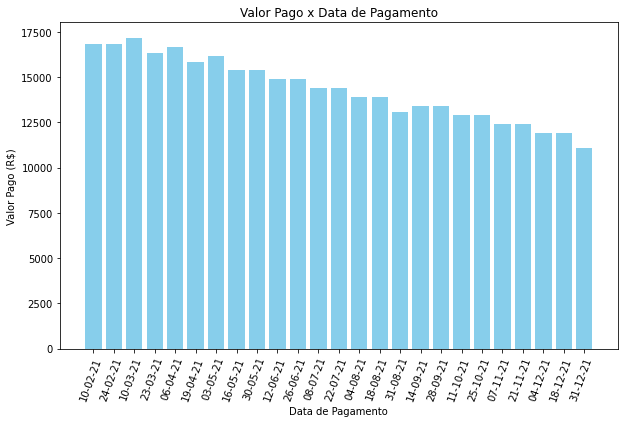

In [ ]:
#Gráfico 1: Valor Pago x Data de Pagamento

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10,  6))

# x-axis e y-axis
ax.bar(previsaoFinal['dataDePagamento'].dt.strftime('%d-%m-%y'),
       previsaoFinal['valorPago'],
       color='skyblue')

# título e labels
ax.set(xlabel="Data de Pagamento",
       ylabel="Valor Pago (R$)",
       title="Valor Pago x Data de Pagamento")

ax.set_xticklabels(labels=previsaoFinal['dataDePagamento'].dt.strftime('%d-%m-%y'), rotation=70, rotation_mode="anchor", ha="right");

plt.show()

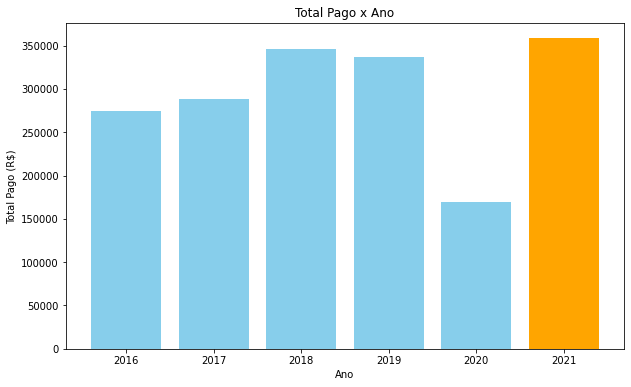

In [ ]:
#Gráfico 2: Total Pago x Ano
import numpy as np

x_total = np.concatenate((x_treino, x_teste), axis=0)
y_total = np.concatenate((y_treino, preditos))

fig, ax = plt.subplots(figsize=(10,  6))

soma_anual = []
ano = 2015
for i in range(y_total.size):
  if dados.iloc[i]['AnoInicial'] == ano:
    soma_anual[len(soma_anual)-1] += dados.iloc[i]['valorPago']
  else:
    ano = ano+1
    soma_anual.append(dados.iloc[i]['valorPago'])
    
somaPrevisao = previsaoFinal['valorPago'].sum()
soma_anual.append(somaPrevisao)

ax.bar([2016, 2017, 2018, 2019, 2020, 2021],
       soma_anual,
       color=['skyblue','skyblue','skyblue','skyblue','skyblue','orange'])

ax.set(xlabel="Ano",
       ylabel="Total Pago (R$)",
       title="Total Pago x Ano")

plt.show()